# Inicializacion e imports

In [1]:
HOST = "http://127.0.0.1:3000/"

PROJECT_NAME = "NPF Detector"
EXPERIMENT_NAME = "512 Gaussian model"
EXPERIMENT_DESCRIPTION = "Inicializo con HInit. Restimo (x3) con HRest. \
                          Guardo los archivos en cm-3.\
                          Subo el numero de gaussianas hasta 512 [1,2,4,8,16,32,64,128,256,512]"

%reload_ext autoreload

%autoreload 2

import src.visualization.visualize as viz
import src.HTK.htktools as htkt
import src.HTK.scripts as scripts

# Inicializo Verta

In [2]:
from verta import Client

client = Client(HOST)
proj = client.set_project(PROJECT_NAME)
expt = client.set_experiment(EXPERIMENT_NAME)
run = client.set_experiment_run(desc=EXPERIMENT_DESCRIPTION)

connection successfully established
set existing Project: NPF Detector from personal workspace
set existing Experiment: 512 Gaussian model
created new ExperimentRun: Run 2325715954607933967905


# Logueo los archivos que voy a usar en el HTK

In [3]:
run.log_artifact("HTK_misc","../src/HTK/misc", overwrite=True)

scripts.display_artifact(which=['config.hcopy'])

upload complete (HTK_misc)
****   src/HTK/misc/config.hcopy   ****

# Coding parameters
SOURCEKIND = USER
TARGETKIND = USER_D_A



# Preparo los datos

Limpio los directorios

In [4]:
scripts.clean_interim()
scripts.clean_models()

Convierto los datos crudos a formato HTK, separando 90% para entrenar y 10% para testear. Tambien creo los archivos necesarios para usar en HTK (train.scp, test.scp)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


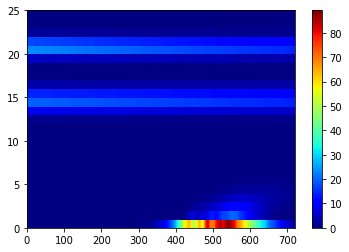

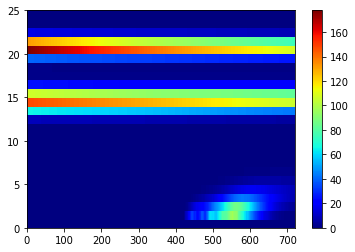

In [5]:
viz.raw_file('0.0-20150124.h5')
viz.raw_file_as_dndlogdp('0.0-20150124.h5')

/home/gfogwil/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


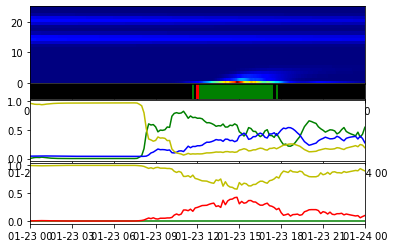

In [7]:
thresholds = {'nuc_threshold': 0.7,       # 1/cm3/10min
             'con_threshold': 220,       # 1/m3^3/10min
             'coa_threshold': 2,         # 1/cm3/10min
             'dep_threshold': 2500}      # 1/m3^3/10min

viz.evaluate_hyperparameter_for_label_debug('0.0-20150123.h5', thresholds)

run.log_hyperparameters(thresholds)

In [8]:
scripts.setup_data(convert_to_dndlogdp=True)
run.log_hyperparameters({'convert_to_dndlogdp': True})

scripts.make_labels(thresholds)

INFO:root:Converting raw files to HTK format ...
INFO:root:Files converted OK!
INFO:root:Creating labels ...
INFO:root:Labels created OK!
INFO:root:Generating script (.scp) files...


Agrego las deltas y las aceleraciones tanto para test como para train:

In [9]:
# Test
n = htkt.HCopy(['-C', '../src/HTK/misc/config.hcopy',
        '-S', '../data/interim/test_hcopy.scp',
        '-T', 1])


run.log_observation('number_of_test_files', n)

# Train
n = htkt.HCopy(['-C', '../src/HTK/misc/config.hcopy',
        '-S', '../data/interim/train_hcopy.scp',
        '-T', 1])

run.log_observation('number_of_train_files', n)


In [10]:
scripts.gen_scp_files()
scripts.gen_MLF()

INFO:root:Generating script (.scp) files...


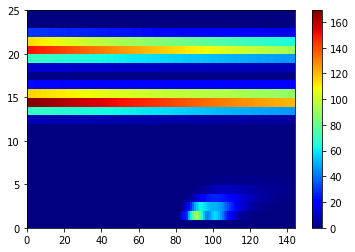

In [16]:
viz.testDA_file()

### Inicializo el modelo de Markov

In [17]:
# Limpio todas todos los modelos y creo el modelo prototipo
scripts.clean_models()

In [18]:
most_trained_model = 0

htkt.HCompV(['-C', '../src/HTK/misc/config',
             '-S', '../data/interim/train.scp',
             '-M', '../models/hmm/' + str(most_trained_model),
             '-T', 1,
             '-f', 1.0,
             '-m',
             '../src/HTK/misc/proto'])

for label in ['nuc', 'coa', 'con', 'equ']:
    htkt.HInit(['-C', '../src/HTK/misc/config',
                '-S', '../data/interim/train.scp',
                '-I', '../data/interim/size_distribution_labels.mlf', 
                '-M', '../models/hmm/' + str(most_trained_model)+'/',
                '-T', 1,
                '-l', label,
                '-o', label,
                '-v', 0.1,
                '../src/HTK/misc/proto'])
    


Calculating Fixed Variance
  HMM Prototype: ../src/HTK/misc/proto
  Segment Label: None
  Num Streams  : 1
  UpdatingMeans: Yes
  Target Direct: ../models/hmm/0
227232 speech frames accumulated
Updating HMM Means and Covariances
Output written to directory ../models/hmm/0
Var floor macros output to file ../models/hmm/0/vFloors

Initialising  HMM ../src/HTK/misc/proto . . . 
 States   :   2  3  4 (width)
 Mixes  s1:   1  1  1 ( 75  )
 Num Using:   0  0  0
 Parm Kind:  USER_D_A
 Number of owners = 1
 SegLab   :  nuc
 maxIter  :  20
 epsilon  :  0.000100
 minSeg   :  3
 Updating :  Means Variances MixWeights/DProbs TransProbs

 - system is PLAIN
590 Observation Sequences Loaded
Starting Estimation Process
Iteration 1: Average LogP = -1100.51160
Iteration 2: Average LogP = -1057.27930  Change =    43.23230
Iteration 3: Average LogP = -1042.33716  Change =    14.94214
Iteration 4: Average LogP = -1029.52527  Change =    12.81189
Iteration 5: Average LogP = -1022.19037  Change =     7.33490


In [19]:
scripts.gen_hmmdefs()
scripts.gen_macros()

Edito el el archivo hmmdefs y le agrego los modelos creados con HInit

### Estimo los parametros

In [26]:
most_trained_model=0
n = 3

for i in range(most_trained_model, most_trained_model + n):
    htkt.HERest(['-C', '../src/HTK/misc/config',
                 '-I', '../data/interim/size_distribution_labels.mlf',
                 '-S', '../data/interim/train.scp',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
                 '-M', '../models/hmm/' + str(most_trained_model+1) + '/',
                 '-t', 250.0,# 150.0, 1000.0,
                 #'-T', 1,
                 '../src/HTK/misc/monophones'])
    
    most_trained_model += 1
    
run.log_artifact('model_1_gaussian', '../models/hmm/' + str(most_trained_model), overwrite=True)

Pruning-On[250.0]

Pruning-On[250.0]

Pruning-On[250.0]

upload complete (model_1_gaussian)


### Evaluo

In [27]:
htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            '-p', 0,
            '-s', 5,
            '-A',
            #'-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test.scp',
            '-i', '../data/interim/results_' + str(1),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])


/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C ../src/HTK/misc/config -H ../models/hmm/3/macros -H ../models/hmm/3/hmmdefs -p 0 -s 5 -A -w ../src/HTK/misc/wdnet -S ../data/interim/test.scp -i ../data/interim/results_1 ../src/HTK/misc/dict ../src/HTK/misc/monophones 



In [28]:
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_' + str(1)])

for k,v in r.items():
    run.log_observation(k,v)

run.log_metric('correct_1_gaussian', r['WORD_Corr'])

====================== HTK Results Analysis =======================
  Date: Thu Jul 23 11:52:39 2020
  Ref : ../data/interim/size_distribution_labels.mlf
  Rec : ../data/interim/results_1
------------------------ Overall Results --------------------------
SENT: %Correct=76.92 [H=120, S=36, N=156]
WORD: %Corr=40.46, Acc=40.46 [H=157, D=230, S=1, I=0, N=388]



### Edito el modelo, ahora uso 2 gaussianas

In [29]:
#most_trained_model = 3
print("Modelo inicial:", most_trained_model)
number_of_gaussians = 2

htkt.HHEd(['-H', '../models/hmm/' + str(most_trained_model) + '/macros',
           '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
           '-M', '../models/hmm/' + str(most_trained_model+1) + '',
           '../src/HTK/misc/pow' + str(number_of_gaussians) + '.hed',
           '../src/HTK/misc/monophones'])

most_trained_model += 1

for i in range(most_trained_model, most_trained_model + n):
    htkt.HERest(['-C', '../src/HTK/misc/config',
                 '-I', '../data/interim/size_distribution_labels.mlf',
                 '-S', '../data/interim/train.scp',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
                 '-M', '../models/hmm/' + str(most_trained_model+1) + '/',
                 '-t', 250.0,# 150.0, 1000.0,
                 #'-T', 1,
                 '../src/HTK/misc/monophones'])
    
    most_trained_model += 1
    
run.log_artifact('model_' + str(number_of_gaussians) + '_gaussian', 
                 '../models/hmm/' + str(most_trained_model), overwrite=True)

print("Modelo Final:", most_trained_model)

htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            '-p', 0,
            '-s', 5,
            '-A',
            '-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test.scp',
            '-i', '../data/interim/results_' + str(number_of_gaussians),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])
            
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_' + str(number_of_gaussians)])

for k,v in r.items():
    run.log_observation(k,v)
    
run.log_metric('correct_2gaussians', r['WORD_Corr'])

Modelo inicial: 3

Pruning-On[250.0]

Pruning-On[250.0]

Pruning-On[250.0]

upload complete (model_2_gaussian)
Modelo Final: 7
/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C ../src/HTK/misc/config -H ../models/hmm/7/macros -H ../models/hmm/7/hmmdefs -p 0 -s 5 -A -T 1 -w ../src/HTK/misc/wdnet -S ../data/interim/test.scp -i ../data/interim/results_2 ../src/HTK/misc/dict ../src/HTK/misc/monophones 
Read 5 physical / 5 logical HMMs
Read lattice with 8 nodes / 16 arcs
Created network with 15 nodes / 23 links
File: ../data/interim/test_D_A/0-20160215
equ nuc dep  ==  [144 frames] 30000001479.1111 [Ac=4320000212992.0 LM=0.0] (Act=12.9)
File: ../data/interim/test_D_A/0-20180718
equ  ==  [144 frames] 30000001479.1111 [Ac=4320000212992.0 LM=0.0] (Act=12.9)
File: ../data/interim/test_D_A/0-20150830
equ  ==  [144 frames] 30000001479.1111 [Ac=4320000212992.0 LM=0.0] (Act=12.9)
File: ../data/interim/test_D_A/0-20190129
equ  ==  [144 frames] 30000001479.1111 [Ac=4320000212992.

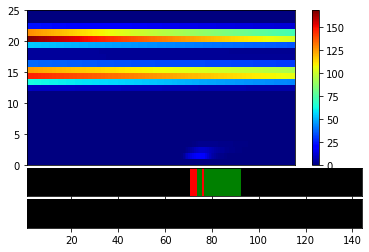

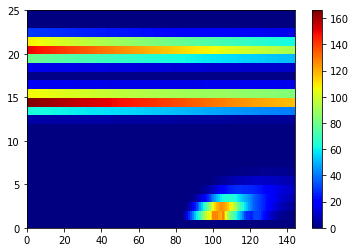

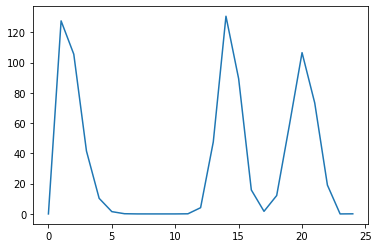

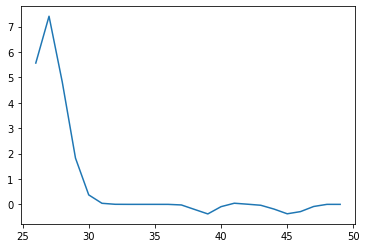

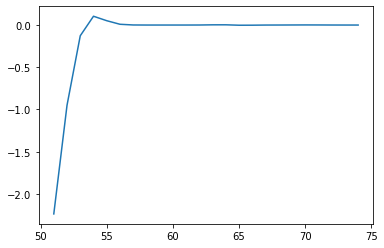

In [33]:
viz.evaluate_results(n_gaussians=2)
viz.testDA_file(sample=100)

### Edito el modelo, ahora uso 4 gaussianas

In [145]:
#most_trained_model = 6
number_of_gaussians = 4

print("Modelo inicial:", most_trained_model)

htkt.HHEd(['-H', '../models/hmm/' + str(most_trained_model) + '/macros',
           '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
           '-M', '../models/hmm/' + str(most_trained_model+1) + '',
           '../src/HTK/misc/pow' + str(number_of_gaussians) + '.hed',
           '../src/HTK/misc/monophones'])

most_trained_model += 1

for i in range(most_trained_model, most_trained_model + n):
    htkt.HERest(['-C', '../src/HTK/misc/config',
                 '-I', '../data/interim/size_distribution_labels.mlf',
                 '-S', '../data/interim/train.scp',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
                 '-M', '../models/hmm/' + str(most_trained_model+1) + '/',
                 '-t', 250.0, 150.0, 1000.0,
                 #'-T', 1,
                 '../src/HTK/misc/monophones'])
    
    most_trained_model += 1
    
print("Modelo final:", most_trained_model)    
    
run.log_artifact('model_' + str(number_of_gaussians) + '_gaussian', 
                 '../models/hmm/' + str(most_trained_model), overwrite=True)

htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            '-p', 0,
            '-s', 5,
            '-A',
            #'-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test.scp',
            '-i', '../data/interim/results_' + str(number_of_gaussians),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])
            
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_' + str(number_of_gaussians)])

for k,v in r.items():
    run.log_observation(k,v)
    
run.log_metric('correct_4_gaussians', r['WORD_Corr'])

Modelo inicial: 7

Pruning-On[250.0 150.0 1000.0]
 WARNING [-7324]  StepBack: File ../data/interim/train_D_A/0-20141231 - bad data or over pruning
 in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HERest

Pruning-On[250.0 150.0 1000.0]
 WARNING [-7324]  StepBack: File ../data/interim/train_D_A/0-20141231 - bad data or over pruning
 in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HERest

Pruning-On[250.0 150.0 1000.0]
 WARNING [-7324]  StepBack: File ../data/interim/train_D_A/0-20141231 - bad data or over pruning
 in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HERest

Modelo final: 11
upload complete (model_4_gaussian)
/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C ../src/HTK/misc/config -H ../models/hmm/11/macros -H ../models/hmm/11/hmmdefs -p 0 -s 5 -A -w ../src/HTK/misc/wdnet -S ../data/interim/test.scp -i ../data/interim/results_4 ../src/HTK/misc/dict ../src/HTK/misc/monophones 

====================== HTK Re

ValueError: metric with key correct_4_gaussians already exists; consider using observations instead

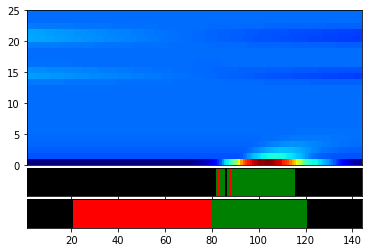

In [155]:
viz.evaluate_results(n_gaussians=4)

### Edito el modelo, ahora uso 8 gaussianas

In [156]:
#most_trained_model = 9
number_of_gaussians = 8

print("Modelo inicial:", most_trained_model)

htkt.HHEd(['-H', '../models/hmm/' + str(most_trained_model) + '/macros',
           '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
           '-M', '../models/hmm/' + str(most_trained_model+1) + '',
           '../src/HTK/misc/pow' + str(number_of_gaussians) + '.hed',
           '../src/HTK/misc/monophones'])


for i in range(most_trained_model, most_trained_model + n):
    htkt.HERest(['-C', '../src/HTK/misc/config',
                 '-I', '../data/interim/size_distribution_labels.mlf',
                 '-S', '../data/interim/train.scp',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
                 '-M', '../models/hmm/' + str(most_trained_model+1) + '/',
                 '-t', 250.0, 150.0, 1000.0,
                 #'-T', 1,
                 '../src/HTK/misc/monophones'])
    
    most_trained_model += 1

print("Modelo final:", most_trained_model)

run.log_artifact('model_' + str(number_of_gaussians) + '_gaussian', 
                 '../models/hmm/' + str(most_trained_model), overwrite=True)

htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            #'-p', 0,
            #'-s', 5,
            '-A',
            #'-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test.scp',
            '-i', '../data/interim/results_' + str(number_of_gaussians),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])
            
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_' + str(number_of_gaussians)])

for k,v in r.items():
    run.log_observation(k,v)

run.log_metric('correct_8_gaussians', r['WORD_Corr'])

Modelo inicial: 11

Pruning-On[250.0 150.0 1000.0]
 WARNING [-7324]  StepBack: File ../data/interim/train_D_A/0-20141231 - bad data or over pruning
 in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HERest

Pruning-On[250.0 150.0 1000.0]
 WARNING [-7324]  StepBack: File ../data/interim/train_D_A/0-20141231 - bad data or over pruning
 in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HERest

Pruning-On[250.0 150.0 1000.0]
 WARNING [-7324]  StepBack: File ../data/interim/train_D_A/0-20141231 - bad data or over pruning
 in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HERest

Modelo final: 14
upload complete (model_8_gaussian)
/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C ../src/HTK/misc/config -H ../models/hmm/14/macros -H ../models/hmm/14/hmmdefs -A -w ../src/HTK/misc/wdnet -S ../data/interim/test.scp -i ../data/interim/results_8 ../src/HTK/misc/dict ../src/HTK/misc/monophones 

====================== HTK Results Ana

### Edito el modelo, ahora uso 16 gaussianas

In [157]:
#most_trained_model = 12
number_of_gaussians = 16

print("Modelo inicial:", most_trained_model)

htkt.HHEd(['-H', '../models/hmm/' + str(most_trained_model) + '/macros',
           '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
           '-M', '../models/hmm/' + str(most_trained_model+1) + '',
           '../src/HTK/misc/pow' + str(number_of_gaussians) + '.hed',
           '../src/HTK/misc/monophones'])

most_trained_model += 1

for i in range(most_trained_model, most_trained_model + n):
    htkt.HERest(['-C', '../src/HTK/misc/config',
                 '-I', '../data/interim/size_distribution_labels.mlf',
                 '-S', '../data/interim/train.scp',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
                 '-M', '../models/hmm/' + str(most_trained_model+1) + '/',
                 '-t', 250.0, 150.0, 1000.0,
                 #'-T', 1,
                 '../src/HTK/misc/monophones'])
    
    most_trained_model += 1

print("Modelo final:", most_trained_model)

run.log_artifact('model_' + str(number_of_gaussians) + '_gaussian', 
                 '../models/hmm/' + str(most_trained_model), overwrite=True)

htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            '-p', 0,
            '-s', 5,
            '-A',
            #'-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test.scp',
            '-i', '../data/interim/results_' + str(number_of_gaussians),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])
            
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_' + str(number_of_gaussians)])

for k,v in r.items():
    run.log_observation(k,v)
    
run.log_metric('correct_16_aussians', r['WORD_Corr'])

Modelo inicial: 14

Pruning-On[250.0 150.0 1000.0]
 WARNING [-7324]  StepBack: File ../data/interim/train_D_A/0-20141231 - bad data or over pruning
 in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HERest

Pruning-On[250.0 150.0 1000.0]

Pruning-On[250.0 150.0 1000.0]

Modelo final: 18
upload complete (model_16_gaussian)
/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C ../src/HTK/misc/config -H ../models/hmm/18/macros -H ../models/hmm/18/hmmdefs -p 0 -s 5 -A -w ../src/HTK/misc/wdnet -S ../data/interim/test.scp -i ../data/interim/results_16 ../src/HTK/misc/dict ../src/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Mon Jul 20 16:33:30 2020
  Ref : ../data/interim/size_distribution_labels.mlf
  Rec : ../data/interim/results_16
------------------------ Overall Results --------------------------
SENT: %Correct=53.76 [H=100, S=86, N=186]
WORD: %Corr=70.37, Acc=42.22 [H=285, D=104, S=16, I=114, N=405]



### Edito el modelo, ahora uso 32 gaussianas

In [158]:
#most_trained_model = 15
number_of_gaussians = 32

print("Modelo inicial:", most_trained_model)

htkt.HHEd(['-H', '../models/hmm/' + str(most_trained_model) + '/macros',
           '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
           '-M', '../models/hmm/' + str(most_trained_model+1) + '',
           '../src/HTK/misc/pow' + str(number_of_gaussians) + '.hed',
           '../src/HTK/misc/monophones'])

most_trained_model += 1


for i in range(most_trained_model, most_trained_model + n):
    htkt.HERest(['-C', '../src/HTK/misc/config',
                 '-I', '../data/interim/size_distribution_labels.mlf',
                 '-S', '../data/interim/train.scp',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
                 '-M', '../models/hmm/' + str(most_trained_model+1) + '/',
                 '-t', 250.0, 150.0, 1000.0,
                 #'-T', 1,
                 '../src/HTK/misc/monophones'])
    
    most_trained_model += 1

print("Modelo final:", most_trained_model)

run.log_artifact('model_' + str(number_of_gaussians) + '_gaussian', 
                 '../models/hmm/' + str(most_trained_model), overwrite=True)

htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            '-p', 0,
            '-s', 5,
            '-A',
            #'-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test.scp',
            '-i', '../data/interim/results_' + str(number_of_gaussians),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])
            
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_' + str(number_of_gaussians)])

for k,v in r.items():
    run.log_observation(k,v)
    
run.log_metric('correct_32_gaussians', r['WORD_Corr'])

Modelo inicial: 18
 WARNING [-2637]  HeaviestMix: mix 1 in equ has v.small gConst [-10000000000.000000] in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HHEd

Pruning-On[250.0 150.0 1000.0]

Pruning-On[250.0 150.0 1000.0]

Pruning-On[250.0 150.0 1000.0]

Modelo final: 22
upload complete (model_32_gaussian)
/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C ../src/HTK/misc/config -H ../models/hmm/22/macros -H ../models/hmm/22/hmmdefs -p 0 -s 5 -A -w ../src/HTK/misc/wdnet -S ../data/interim/test.scp -i ../data/interim/results_32 ../src/HTK/misc/dict ../src/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Mon Jul 20 16:34:02 2020
  Ref : ../data/interim/size_distribution_labels.mlf
  Rec : ../data/interim/results_32
------------------------ Overall Results --------------------------
SENT: %Correct=55.91 [H=104, S=82, N=186]
WORD: %Corr=69.38, Acc=44.44 [H=281, D=107, S=17, I=101, N=405]



### Edito el modelo, ahora uso 64 gaussianas

In [159]:
#most_trained_model = 18
number_of_gaussians = 64

print("Modelo inicial:", most_trained_model)

htkt.HHEd(['-H', '../models/hmm/' + str(most_trained_model) + '/macros',
           '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
           '-M', '../models/hmm/' + str(most_trained_model+1) + '',
           '../src/HTK/misc/pow' + str(number_of_gaussians) + '.hed',
           '../src/HTK/misc/monophones'])

most_trained_model += 1

for i in range(most_trained_model, most_trained_model + n):
    htkt.HERest(['-C', '../src/HTK/misc/config',
                 '-I', '../data/interim/size_distribution_labels.mlf',
                 '-S', '../data/interim/train.scp',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
                 '-M', '../models/hmm/' + str(most_trained_model+1) + '/',
                 '-t', 250.0, 150.0, 1000.0,
                 #'-T', 1,
                 '../src/HTK/misc/monophones'])
    
    most_trained_model += 1

print("Modelo final:", most_trained_model)

run.log_artifact('model_' + str(number_of_gaussians) + '_gaussian', 
                 '../models/hmm/' + str(most_trained_model), overwrite=True)

htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            '-p', 0,
            '-s', 5,
            '-A',
            #'-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test.scp',
            '-i', '../data/interim/results_' + str(number_of_gaussians),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])
            
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_' + str(number_of_gaussians)])

for k,v in r.items():
    run.log_observation(k,v)
    
run.log_metric('correct_64_gaussians', r['WORD_Corr'])

Modelo inicial: 22
 WARNING [-2637]  HeaviestMix: mix 1 in dep has v.small gConst [-10000000000.000000] in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HHEd
 WARNING [-2637]  HeaviestMix: mix 32 in dep has v.small gConst [-10000000000.000000] in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HHEd

Pruning-On[250.0 150.0 1000.0]

Pruning-On[250.0 150.0 1000.0]

Pruning-On[250.0 150.0 1000.0]

Modelo final: 26
upload complete (model_64_gaussian)
/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C ../src/HTK/misc/config -H ../models/hmm/26/macros -H ../models/hmm/26/hmmdefs -p 0 -s 5 -A -w ../src/HTK/misc/wdnet -S ../data/interim/test.scp -i ../data/interim/results_64 ../src/HTK/misc/dict ../src/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Mon Jul 20 16:35:00 2020
  Ref : ../data/interim/size_distribution_labels.mlf
  Rec : ../data/interim/results_64
------------------------ Overall Res

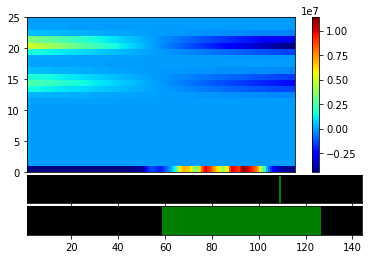

In [223]:
viz.evaluate_results(n_gaussians=64)

### Edito el modelo, ahora uso 128 gaussianas

In [161]:
most_trained_model = 21
number_of_gaussians = 128

print("Modelo inicial:", most_trained_model)

htkt.HHEd(['-H', '../models/hmm/' + str(most_trained_model) + '/macros',
           '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
           '-M', '../models/hmm/' + str(most_trained_model+1) + '',
           '../src/HTK/misc/pow' + str(number_of_gaussians) + '.hed',
           '../src/HTK/misc/monophones'])


for i in range(most_trained_model, most_trained_model + n):
    htkt.HERest(['-C', '../src/HTK/misc/config',
                 '-I', '../data/interim/size_distribution_labels.mlf',
                 '-S', '../data/interim/train.scp',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
                 '-M', '../models/hmm/' + str(most_trained_model+1) + '/',
                 '-t', 250.0, 150.0, 1000.0,
                 #'-T', 1,
                 '../src/HTK/misc/monophones'])
    
    most_trained_model += 1

print("Modelo final:", most_trained_model)

run.log_artifact('model_' + str(number_of_gaussians) + '_gaussian', 
                 '../models/hmm/' + str(most_trained_model), overwrite=True)

htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            '-p', 0,
            '-s', 5,
            '-A',
            #'-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test.scp',
            '-i', '../data/interim/results_' + str(number_of_gaussians),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])
            
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_' + str(number_of_gaussians)])

for k,v in r.items():
    run.log_observation(k,v)
    
run.log_metric('correct_128_gaussians', r['WORD_Corr'])

Modelo inicial: 21
/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HHEd -H ../models/hmm/21/macros -H ../models/hmm/21/hmmdefs -M ../models/hmm/22 ../src/HTK/misc/pow128.hed ../src/HTK/misc/monophones
 WARNING [-2637]  HeaviestMix: mix 1 in dep has v.small gConst [-10000000000.000000] in /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HHEd
  ERROR [+2697]  HeaviestMix:  heaviest mix is defunct!
 FATAL ERROR - Terminating program /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HHEd
Pruning-On[250.0 150.0 1000.0]

Pruning-On[250.0 150.0 1000.0]

Pruning-On[250.0 150.0 1000.0]

Modelo final: 24
upload complete (model_128_gaussian)
/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C ../src/HTK/misc/config -H ../models/hmm/24/macros -H ../models/hmm/24/hmmdefs -p 0 -s 5 -A -w ../src/HTK/misc/wdnet -S ../data/interim/test.scp -i ../data/interim/results_128 ../src/HTK/misc/dict ../src/HTK/misc/monophones 

====================== HTK

### Edito el modelo, ahora uso 256 gaussianas

In [162]:
most_trained_model = 24
number_of_gaussians = 256

print("Modelo inicial:", most_trained_model)

htkt.HHEd(['-H', '../models/hmm/' + str(most_trained_model) + '/macros',
           '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
           '-M', '../models/hmm/' + str(most_trained_model+1) + '',
           '../src/HTK/misc/pow' + str(number_of_gaussians) + '.hed',
           '../src/HTK/misc/monophones'])


for i in range(most_trained_model, most_trained_model + n):
    htkt.HERest(['-C', '../src/HTK/misc/config',
                 '-I', '../data/interim/size_distribution_labels.mlf',
                 '-S', '../data/interim/train.scp',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
                 '-M', '../models/hmm/' + str(most_trained_model+1) + '/',
                 '-t', 250.0, 150.0, 1000.0,
                 #'-T', 1,
                 '../src/HTK/misc/monophones'])
    
    most_trained_model += 1

print("Modelo final:", most_trained_model)

run.log_artifact('model_' + str(number_of_gaussians) + '_gaussian', 
                 '../models/hmm/' + str(most_trained_model), overwrite=True)

htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            '-p', 0,
            '-s', 5,
            '-A',
            #'-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test.scp',
            '-i', '../data/interim/results_' + str(number_of_gaussians),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])
            
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_' + str(number_of_gaussians)])

for k,v in r.items():
    run.log_observation(k,v)
    
run.log_metric('correct_256_gaussians', r['WORD_Corr'])

Modelo inicial: 24
/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HHEd -H ../models/hmm/24/macros -H ../models/hmm/24/hmmdefs -M ../models/hmm/25 ../src/HTK/misc/pow256.hed ../src/HTK/misc/monophones
  ERROR [+2697]  HeaviestMix:  heaviest mix is defunct!
 FATAL ERROR - Terminating program /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HHEd
Pruning-On[250.0 150.0 1000.0]

Pruning-On[250.0 150.0 1000.0]

Pruning-On[250.0 150.0 1000.0]

Modelo final: 27
upload complete (model_256_gaussian)
/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C ../src/HTK/misc/config -H ../models/hmm/27/macros -H ../models/hmm/27/hmmdefs -p 0 -s 5 -A -w ../src/HTK/misc/wdnet -S ../data/interim/test.scp -i ../data/interim/results_256 ../src/HTK/misc/dict ../src/HTK/misc/monophones 

====================== HTK Results Analysis =======================
  Date: Mon Jul 20 16:36:28 2020
  Ref : ../data/interim/size_distribution_labels.mlf
  Rec : ../data/interim/res

### Edito el modelo, ahora uso 512 gaussianas

In [172]:
most_trained_model = 27
number_of_gaussians = 512

print("Modelo inicial:", most_trained_model)

htkt.HHEd(['-H', '../models/hmm/' + str(most_trained_model) + '/macros',
           '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
           '-M', '../models/hmm/' + str(most_trained_model+1) + '',
           '../src/HTK/misc/pow' + str(number_of_gaussians) + '.hed',
           '../src/HTK/misc/monophones'])


for i in range(most_trained_model, most_trained_model + n):
    htkt.HERest(['-C', '../src/HTK/misc/config',
                 '-I', '../data/interim/size_distribution_labels.mlf',
                 '-S', '../data/interim/train.scp',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
                 '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
                 '-M', '../models/hmm/' + str(most_trained_model+1) + '/',
                 '-t', 250.0, 150.0, 1000.0,
                 #'-T', 1,
                 '../src/HTK/misc/monophones'])
    
    most_trained_model += 1

print("Modelo final:", most_trained_model)

run.log_artifact('model_' + str(number_of_gaussians) + '_gaussian', 
                 '../models/hmm/' + str(most_trained_model), overwrite=True)

htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            '-p', 0,
            '-s', 5,
            '-A',
            '-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test.scp',
            '-i', '../data/interim/results_' + str(number_of_gaussians),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])
            
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_' + str(number_of_gaussians)])

for k,v in r.items():
    run.log_observation(k,v)
    
run.log_metric('correct_512_gaussians', r['WORD_Corr'])

Modelo inicial: 27
/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HHEd -H ../models/hmm/27/macros -H ../models/hmm/27/hmmdefs -M ../models/hmm/28 ../src/HTK/misc/pow512.hed ../src/HTK/misc/monophones
  ERROR [+2697]  HeaviestMix:  heaviest mix is defunct!
 FATAL ERROR - Terminating program /home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HHEd
Pruning-On[250.0 150.0 1000.0]

Pruning-On[250.0 150.0 1000.0]

Pruning-On[250.0 150.0 1000.0]

Modelo final: 30
upload complete (model_512_gaussian)
/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C ../src/HTK/misc/config -H ../models/hmm/30/macros -H ../models/hmm/30/hmmdefs -p 0 -s 5 -A -T 1 -w ../src/HTK/misc/wdnet -S ../data/interim/test.scp -i ../data/interim/results_512 ../src/HTK/misc/dict ../src/HTK/misc/monophones 
Read 5 physical / 5 logical HMMs
Read lattice with 8 nodes / 16 arcs
Created network with 15 nodes / 23 links
File: ../data/interim/test_D_A/0-20170720
equ dep equ  ==  [144 fra

ValueError: metric with key correct_512_gaussians already exists; consider using observations instead

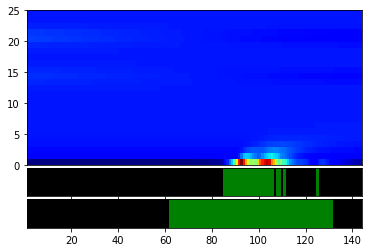

In [171]:
viz.evaluate_results(n_gaussians=512)

### Evaluo algunos casos reales

In [231]:
htkt.HVite(['-C', '../src/HTK/misc/config',
            '-H', '../models/hmm/' + str(most_trained_model) + '/macros',
            '-H', '../models/hmm/' + str(most_trained_model) + '/hmmdefs',
            '-p', 0,
            '-s', 5,
            '-A',
            '-T', 1,
            '-w', '../src/HTK/misc/wdnet',
            '-S', '../data/interim/test_real_data.scp',
            '-i', '../data/interim/results_real_' + str(number_of_gaussians),
            '../src/HTK/misc/dict',
            '../src/HTK/misc/monophones'])
            
r = htkt.HResults(['-I', '../data/interim/size_distribution_labels.mlf', 
                   '../src/HTK/misc/monophones', 
                   '../data/interim/results_real_' + str(number_of_gaussians)])

# for k,v in r.items():
#     run.log_observation(k,v)
    
# run.log_metric('correct_512_gaussians', r['WORD_Corr'])

/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HVite -C ../src/HTK/misc/config -H ../models/hmm/30/macros -H ../models/hmm/30/hmmdefs -p 0 -s 5 -A -T 1 -w ../src/HTK/misc/wdnet -S ../data/interim/test_real_data.scp -i ../data/interim/results_real_512 ../src/HTK/misc/dict ../src/HTK/misc/monophones 
Read 5 physical / 5 logical HMMs
Read lattice with 8 nodes / 16 arcs
Created network with 15 nodes / 23 links
File: ../data/external/DM20171110
No tokens survived to final node of network
File: ../data/external/DM20171113
No tokens survived to final node of network
File: ../data/external/DM20171115
equ equ equ equ equ equ equ  ==  [144 frames] -1399200.5556 [Ac=-201484880.0 LM=0.0] (Act=12.9)

/home/gfogwil/Documentos/Facultad/Tesis/programs/htk/HTKTools/HResults -I ../data/interim/size_distribution_labels.mlf ../src/HTK/misc/monophones ../data/interim/results_real_512
  ERROR [+6510]  LOpen: Unable to open label file ../data/external/DM20171115.lab
 FATAL ERROR - Terminating 

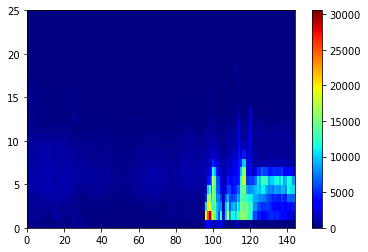

In [232]:
viz.real_file('DM20171115')